Demonstrates distribution of error of the numerical solution for two different approximation orders and two different discretization magnitudes $h$.

Author: Mitja Jančič

Institute Jozef Stefan 2022

# Import libs

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import h5py as h5
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from matplotlib import projections
from numpy import linalg as LA
import scipy as sp
import scipy.interpolate

from photutils.utils import ShepardIDWInterpolator as idw
from sklearn.neighbors import KDTree


In [2]:
# To run interactive plot.
from matplotlib import interactive
interactive(True)
%matplotlib qt


In [2]:
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "text.usetex": False,
    "axes.formatter.use_mathtext": True,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.labelsize": 14
})



# Plot

In [3]:
marker_size_scatter = 10
iteration = 19

file_id = 4
data_filepath = '../data/final/results_boussinesq_hp_e5.h5'
print(data_filepath)


../data/final/results_boussinesq_hp_e5.h5


# Plot domain

Types:  [2 4 6]
type: 2 ,number: 74391
type: 4 ,number: 5937
type: 6 ,number: 130


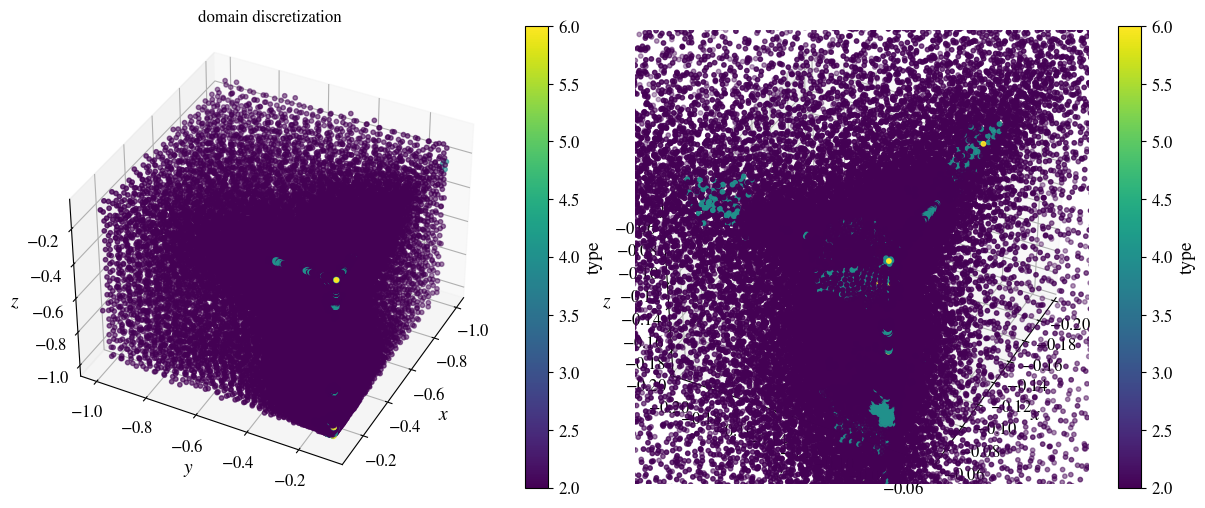

In [5]:
# Import data.
data = h5.File(data_filepath, 'r')

# Obtain HDf groups.
groups = list(data.keys())


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')

pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
typ = np.abs(data['domain_{:05d}/types'.format(iteration)][:])
print("Types: ", np.unique(typ))
for t in np.unique(typ):
    print("type:", t, ",number:", sum(typ == t))

p = ax.scatter(pos[0], pos[1], pos[2], c=typ, s=marker_size_scatter)
# for i in range(len(pos[0])):
#     x = pos[0][i]
#     y = pos[1][i]
#     t = typ[i]
#     ax.text(x, y, t)
plt.grid('both')
ax.set_title("domain discretization")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

cbar = fig.colorbar(p, ax=ax, shrink=0.6, label="type")

ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.scatter(pos[0], pos[1], pos[2], c=typ, s=marker_size_scatter)
ax.set_xlim(-0.2, -0.05)
ax.set_ylim(-0.2, -0.05)
ax.set_zlim(-0.2, -0.05)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)
cbar = fig.colorbar(p, ax=ax, shrink=0.6, label="type")

fig.tight_layout()

data.close()


## Plot solution

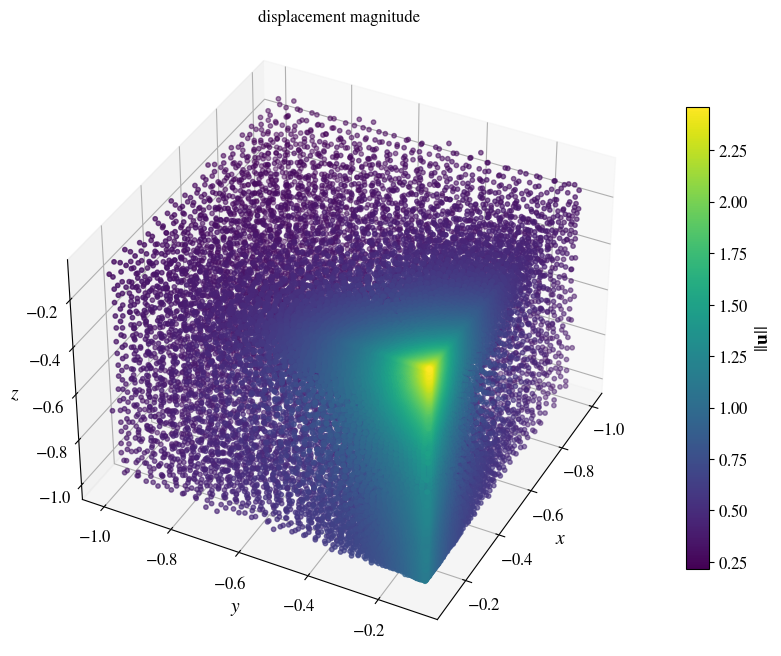

In [6]:
# Import data.
data = h5.File(data_filepath, 'r')

# Obtain HDf groups.
groups = list(data.keys())


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
disp = data['disp_implicit_{:05d}'.format(iteration)][:]
displacement_mag = [np.sqrt(x*x + y*y + z*z)
                    for x, y, z in zip(disp[0], disp[1], disp[2])]

p = ax.scatter(pos[0], pos[1], pos[2],
               c=displacement_mag, s=marker_size_scatter)
# for i in range(len(pos[0])):
#     x = pos[0][i]
#     y = pos[1][i]
#     t = typ[i]
#     ax.text(x, y, t)
plt.grid('both')
ax.set_title("displacement magnitude")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

cbar = fig.colorbar(p, ax=ax, shrink=0.6,
                    label=r"$\left\|\left\|\mathbf{u} \right\|\right\|$")

fig.tight_layout()

data.close()


In [7]:
# Import data.
data = h5.File(data_filepath, 'r')

# Obtain HDf groups.
groups = list(data.keys())


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
disp = data['disp_implicit_{:05d}'.format(iteration)][:]
displacement_mag = [np.sqrt(x*x + y*y + z*z)
                    for x, y, z in zip(disp[0], disp[1], disp[2])]

coeff = 0.1
p = ax.scatter(pos[0] + coeff * disp[0], pos[1] + coeff * disp[0], pos[2] + coeff * disp[0],
               c=displacement_mag, s=marker_size_scatter)
# for i in range(len(pos[0])):
#     x = pos[0][i]
#     y = pos[1][i]
#     t = typ[i]
#     ax.text(x, y, t)
plt.grid('both')
ax.set_title("displacements")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

cbar = fig.colorbar(p, ax=ax, shrink=0.6,
                    label=r"$\left\|\left\|\mathbf{u} \right\|\right\|$")

fig.tight_layout()

data.close()


In [7]:
def get_vms(sxx, syy, szz, sxy, sxz, syz):
    return np.sqrt(0.5*(np.power(sxx - syy, 2) + np.power(syy - szz, 2) + np.power(szz - sxx, 2) + 6*(np.power(sxy, 2) + np.power(sxz, 2) + np.power(syz, 2))))


In [9]:
# Import data.
data = h5.File(data_filepath, 'r')

# Obtain HDf groups.
groups = list(data.keys())


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
stress = data['stress_implicit_{:05d}'.format(iteration)][:]
sxx = stress[0]
syy = stress[1]
szz = stress[2]
sxy = stress[3]
sxz = stress[4]
syz = stress[5]
vms = get_vms(sxx, syy, szz, sxy, sxz, syz)

p = ax.scatter(pos[0], pos[1], pos[2], c=vms, s=marker_size_scatter)
plt.grid('both')
ax.set_title("von Mises stress")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

cbar = fig.colorbar(p, ax=ax, shrink=0.6, label=r"$\sigma_{VMS}$")

fig.tight_layout()

data.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


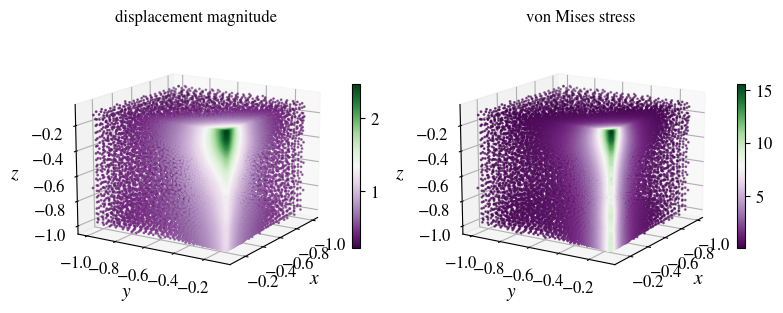

In [8]:
# Import data.
data = h5.File(data_filepath, 'r')

# *******************
# Displacement field.
# *******************

fig = plt.figure(figsize=(8, 3.15))
ax = fig.add_subplot(1, 2, 1, projection='3d')

pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
disp = data['disp_implicit_{:05d}'.format(iteration)][:]
displacement_mag = [np.sqrt(x*x + y*y + z*z)
                    for x, y, z in zip(disp[0], disp[1], disp[2])]

p = ax.scatter(pos[0], pos[1], pos[2], cmap="PRGn",
               c=displacement_mag, s=1)
# for i in range(len(pos[0])):
#     x = pos[0][i]
#     y = pos[1][i]
#     t = typ[i]
#     ax.text(x, y, t)
plt.grid('both')
ax.set_title("displacement magnitude")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=15, azim=32)

cbar = fig.colorbar(p, ax=ax, shrink=0.6)

# *****************
# Von Mises stress.
# *****************
ax = fig.add_subplot(1, 2, 2, projection='3d')

pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
stress = data['stress_implicit_{:05d}'.format(iteration)][:]
sxx = stress[0]
syy = stress[1]
szz = stress[2]
sxy = stress[3]
sxz = stress[4]
syz = stress[5]
vms = get_vms(sxx, syy, szz, sxy, sxz, syz)

p = ax.scatter(pos[0], pos[1], pos[2], c=vms, cmap="PRGn", s=1)
plt.grid('both')
ax.set_title("von Mises stress")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=15, azim=32)
cbar = fig.colorbar(p, ax=ax, shrink=0.6)

fig.tight_layout()

data.close()

if 1:
    plt.savefig('../manuscript/figures/boussinesq_solution.eps', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()


In [11]:
len(vms)

80458

## Analytic error

In [9]:
def analytic(x, y, z, P, E, nu):
    r = [np.sqrt(x[i] ** 2 + y[i] ** 2) for i in range(len(x))]
    R = [np.sqrt(x[i] ** 2 + y[i] ** 2 + z[i] ** 2) for i in range(len(x))]
    ct = [x[i] / r[i] for i in range(len(x))]
    st = [y[i] / r[i] for i in range(len(x))]

    mu = E / (2*(1+nu))

    ur = [P*r[i]/(4*np.pi*mu) * (z[i] / R[i] ** 3 - (1-2*nu) /
                                 (R[i]*(z[i]+R[i]))) for i in range(len(x))]

    w = [P/(4*np.pi*mu) * (z[i] ** 2 / R[i] ** 3 + 2*(1-nu) / R[i])
         for i in range(len(x))]

    u = [ur[i] * ct[i] for i in range(len(x))]
    v = [ur[i] * st[i] for i in range(len(x))]

    srr = [P/(2*np.pi)*((1-2*nu) / (R[i]*(R[i]+z[i])) - 3 *
                        r[i] ** 2*z[i]/R[i] ** 5) for i in range(len(x))]
    szz = [-3*P/(2*np.pi)*z[i] ** 3/R[i] ** 5 for i in range(len(x))]
    stt = [P/(2*np.pi)*(1-2*nu)*(z[i]/R[i] ** 3 - 1 / (R[i]*(R[i]+z[i])))
           for i in range(len(x))]
    srz = [-3*P/(2*np.pi)*r[i]*z[i] ** 2/R[i] ** 5 for i in range(len(x))]

    sxx = np.array([srr[i] * ct[i] ** 2 + stt[i] *
                   st[i] ** 2 for i in range(len(x))])
    sxy = np.array([(srr[i]-stt[i]) * ct[i]*st[i] for i in range(len(x))])
    sxz = np.array([srz[i]*ct[i] for i in range(len(x))])
    syy = np.array([stt[i]*ct[i] ** 2 + srr[i]*st[i]
                   ** 2 for i in range(len(x))])
    syz = np.array([srz[i]*st[i] for i in range(len(x))])

    return [u, v, w, sxx, syy, szz, sxy, sxz, syz]


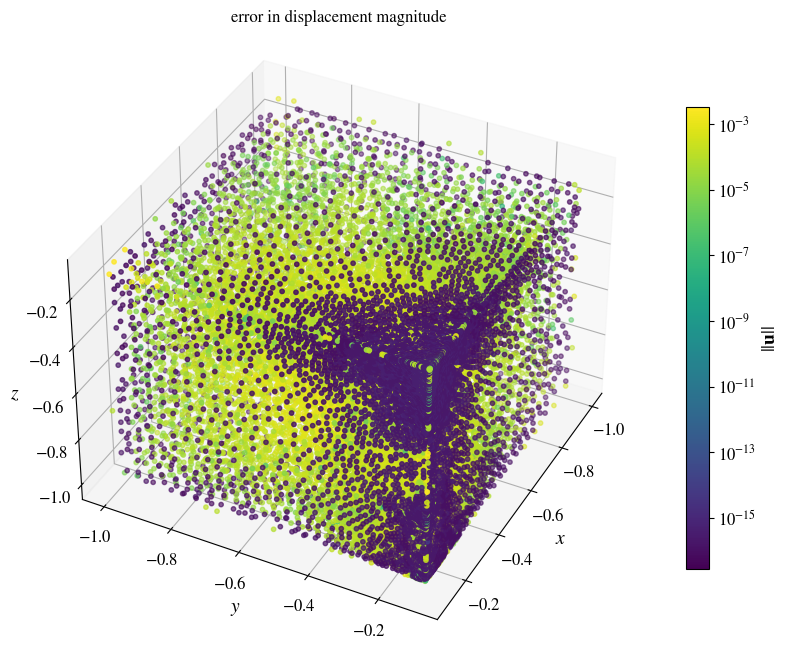

In [10]:
# Import data.
data = h5.File(data_filepath, 'r')

# Obtain HDf groups.
groups = list(data.keys())


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
disp = data['disp_implicit_{:05d}'.format(iteration)][:]
displacement_mag = [np.sqrt(x*x + y*y + z*z)
                    for x, y, z in zip(disp[0], disp[1], disp[2])]
disp_x, disp_y, disp_z = analytic(pos[0], pos[1], pos[2], -1, 1, 0.33)[:3]
displacement_mag_analytic = [np.sqrt(x*x+y*y+z*z)
                             for x, y, z in zip(disp_x, disp_y, disp_z)]

err = np.abs(np.array(displacement_mag) - np.array(displacement_mag_analytic))
p = ax.scatter(pos[0], pos[1], pos[2], c=err,
               s=marker_size_scatter, norm=matplotlib.colors.LogNorm())
plt.grid('both')
ax.set_title("error in displacement magnitude")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

cbar = fig.colorbar(p, ax=ax, shrink=0.6,
                    label=r"$\left\|\left\|\mathbf{u} \right\|\right\|$")

fig.tight_layout()

data.close()


# Indicator field

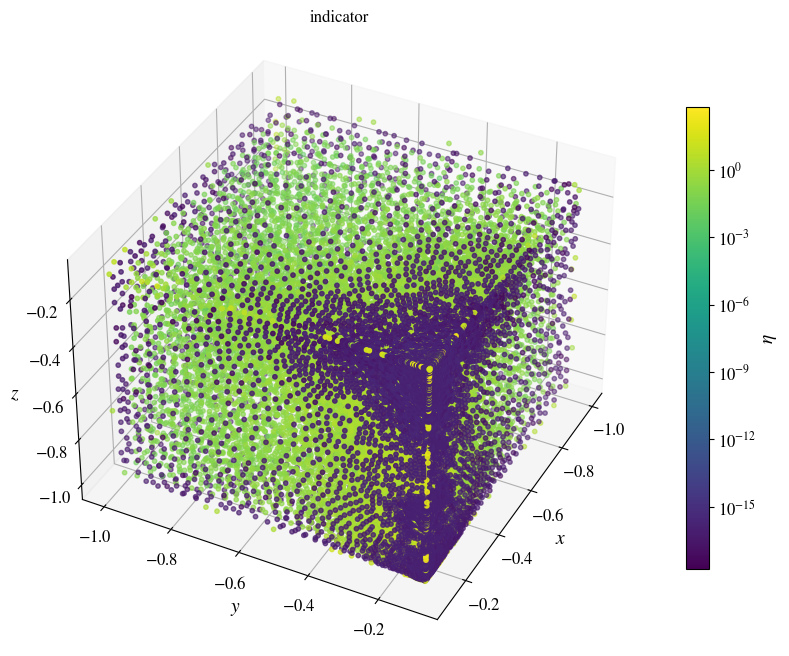

In [11]:
# Import data.
data = h5.File(data_filepath, 'r')

# Obtain HDf groups.
groups = list(data.keys())


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Scatter.
pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
err = data['indicator_{:05d}'.format(iteration)][:]
p = ax.scatter(pos[0], pos[1], pos[2], c=err,
               s=marker_size_scatter, norm=matplotlib.colors.LogNorm())
plt.grid('both')
ax.set_title("indicator")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

cbar = fig.colorbar(p, ax=ax, shrink=0.6, label=r"$\eta$")

fig.tight_layout()

data.close()


# Iteration and node count

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


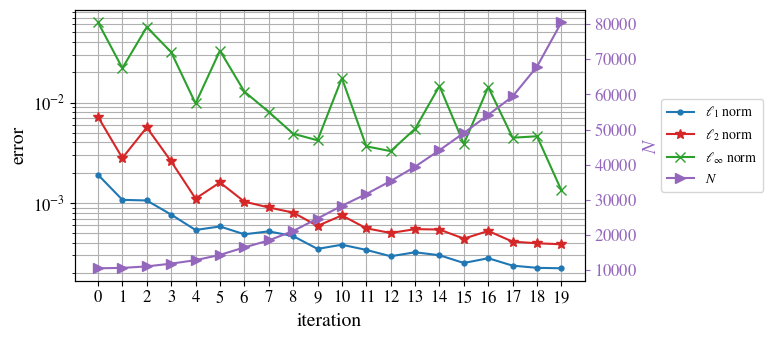

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
plots = []
markers= [".", "*", "x", ">"]
for file_id in ['hp']:
    # Import data.
    data = h5.File('../data/final/results_boussinesq_{}_e5.h5'.format(file_id), 'r')
    # data = h5.File('../data/results_007068.h5', 'r')

    # Iterations
    N_iter = data.attrs['refinement_iterations']
    nodes = [data.attrs['N_{:05d}'.format(i)] for i in range(N_iter)]
    N = np.arange(0, N_iter)
    errors_1 = []
    errors_2 = []
    errors_inf = []
    for i in range(N_iter):
        pos = data['domain_{:05d}/pos'.format(i)][:]
        # Displacements.
        disp_num = data['disp_implicit_{:05d}'.format(i)][:]
        disp_x, disp_y, disp_z = analytic(
            pos[0], pos[1], pos[2], -1, 1, 0.33)[:3]
        # Displacements magnitude.
        displacement_mag_analytic = [
            np.sqrt(x*x+y*y+z*z) for x, y, z in zip(disp_x, disp_y, disp_z)]
        disp_num_magnitude = [np.sqrt(
            x*x + y*y + z*z) for x, y, z in zip(disp_num[0], disp_num[1], disp_num[2])]

        # Error.
        err = np.array(displacement_mag_analytic) - \
            np.array(disp_num_magnitude)
        err_norm = LA.norm(err, 1) / \
            LA.norm(displacement_mag_analytic, 1)
        errors_1.append(err_norm)

        err = np.array(displacement_mag_analytic) - \
            np.array(disp_num_magnitude)
        err_norm = LA.norm(err, 2) / \
            LA.norm(displacement_mag_analytic, 2)
        errors_2.append(err_norm)

        err = np.array(displacement_mag_analytic) - \
            np.array(disp_num_magnitude)
        err_norm = LA.norm(err, np.inf) / \
            LA.norm(displacement_mag_analytic, np.inf)
        errors_inf.append(err_norm)

    data.close()

    p, = ax.plot(N, errors_1, '-', label=r'error - $\ell_1$ norm', c='tab:blue', ms=7, marker=markers[0])
    plots.append(p)
    p, = ax.plot(N, errors_2, '-', label=r'error - $\ell_2$ norm', c='tab:red', ms=7, marker=markers[1])
    plots.append(p)
    p, = ax.plot(N, errors_inf, '-', label=r'error - $\ell_\infty$ norm', c='tab:green', ms=7, marker=markers[2])
    plots.append(p)

    ax.set_xticks(N)
    ax1 = ax.twinx()
    p, = ax1.plot(N, nodes, '-',  ms=7, c='tab:purple', marker=markers[3])
    plots.append(p)
    ax1.set_ylabel(r'$N$')
    ax1.tick_params(axis='y', colors=p.get_color())
    ax1.yaxis.label.set_color(p.get_color())
ax.grid(True, 'both')
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'error')
ax.set_yscale('log')
# ax.legend()

ax.legend(plots, [r'$\ell_1$ norm', r'$\ell_2$ norm', r'$\ell_\infty$ norm', r'$N$'], bbox_to_anchor=(1.15, 0.5), loc="center left", borderaxespad=0)

fig.tight_layout()

if 1:
    plt.savefig('../manuscript/figures/boussinesq_convergence.eps', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()


## Max indicator vs iteration

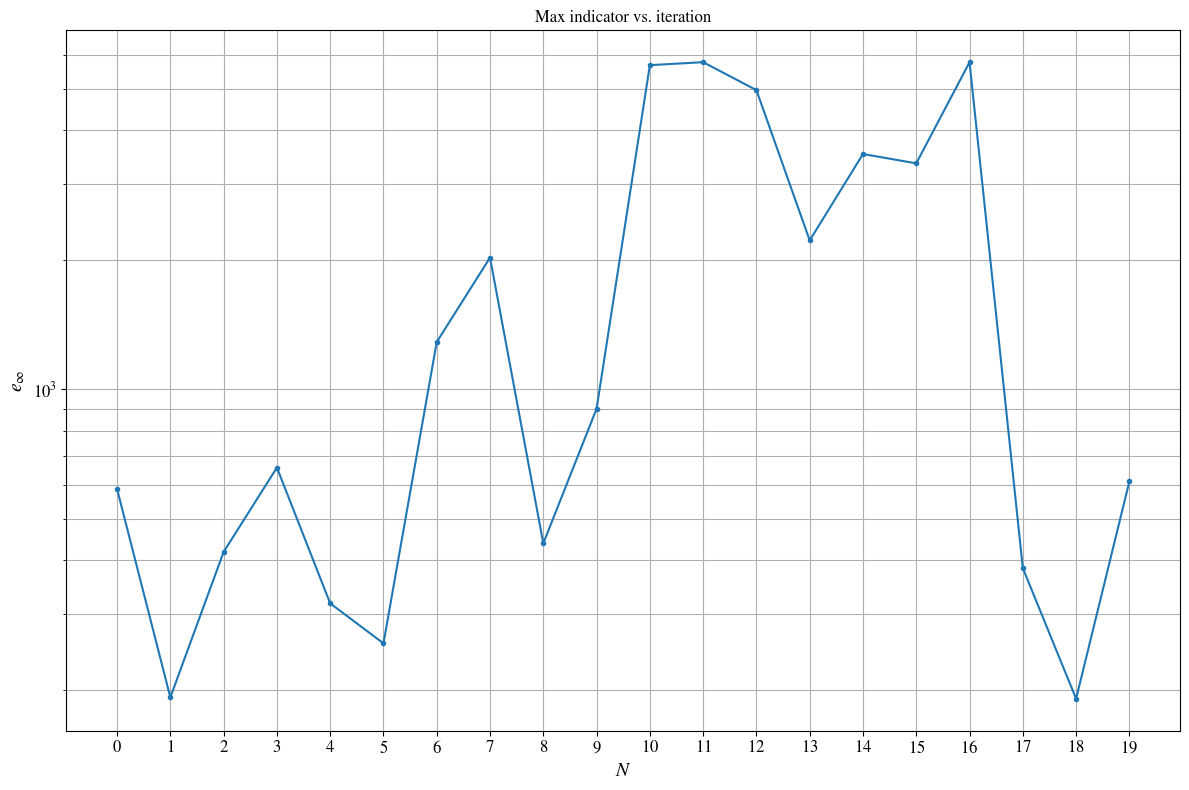

In [14]:
# Import data.
data = h5.File(data_filepath, 'r')

# Iterations
N_iter = data.attrs['refinement_iterations']

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

N = np.arange(0, N_iter)
max_indicator = [
    data.attrs['max_indicator_{:05d}'.format(i)] for i in range(N_iter)]

p = ax.plot(N, max_indicator, '.-')
ax.grid(True, 'both')
ax.set_title("Max indicator vs. iteration")
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$e_{\infty}$')
ax.set_yscale('log')
ax.set_xticks(N)

fig.tight_layout()

data.close()


# Plot for different epsilons

In [16]:
# fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# for i in range(5):
#     for adaptivity in ['h', 'hp']:
#         file = '../data/final/results_boussinesq_{}_e{}.h5'.format(
#             adaptivity, i)
#         data = h5.File(file, 'r')
#         # Read data.
#         N_iter = data.attrs['refinement_iterations']
#         error = [data.attrs['err_norm_inf_{:05d}'.format(
#             i)] for i in range(N_iter)]
#         N = [data.attrs['N_{:05d}'.format(i)] for i in range(N_iter)]
#         epsilon = data['conf'].attrs.get('case.eps')

#         min_error = np.min(error)
#         best_idx = error.index(min_error)

#         ax.scatter(epsilon, min_error, c='tab:blue' if adaptivity == 'h' else 'tab:red',
#                    s=marker_size_scatter, label=r'${}$-adaptive'.format(adaptivity) if i == 0 else None)
#         ax.set_yscale('log')
#         ax.text(epsilon, min_error,
#                 N[best_idx], c='tab:blue' if adaptivity == 'h' else 'tab:red')

#         print("File: ", file, ", min_error = ",
#               min_error, ", epsilon = ", epsilon)
#         data.close()

# ax.set_xlabel(r'$\varepsilon$')
# ax.set_ylabel(r'$e_{\infty}$')
# ax.grid('both')
# ax.legend()
# fig.tight_layout()

# if 1:
#     plt.savefig('../manuscript/figures/boussinesq_eps.pdf', dpi=300,
#                 transparent=False, bbox_inches='tight')
# plt.show()


# Plot diagonal per iteration

In [17]:
# Load data.
file = '../data/final/results_boussinesq_hp_e6.h5'
data = h5.File(file, 'r')
pos = data['domain_00000/pos'][:]
x_min = min(pos[0])
x_max = max(pos[0])
N_iter = data.attrs['refinement_iterations']
data.close()

# Obtain analytic solution
coord_test = np.linspace(x_min, x_max, 100)
disp_x, disp_y, disp_z, sxx, syy, szz, sxy, sxz, syz = analytic(
    coord_test, coord_test, coord_test, -1, 1, 0.33)
vms_analytic = get_vms(sxx, syy, szz, sxy, sxz, syz)

# Plot iterations.
iteration_idxs = np.arange(0, N_iter)
fig, axs = plt.subplots(4, 5, figsize=(20, 15))
data = h5.File(file, 'r')
for i, ax in enumerate(axs.flatten()):
    pos = np.array(
        data['domain_{:05d}/pos'.format(iteration_idxs[i])][:]).transpose()
    stress = data['stress_implicit_{:05d}'.format(iteration_idxs[i])][:]
    sxx = stress[0]
    syy = stress[1]
    szz = stress[2]
    sxy = stress[3]
    sxz = stress[4]
    syz = stress[5]
    vms = get_vms(sxx, syy, szz, sxy, sxz, syz)

    # Build Sheppards interpolant.
    sheppard = idw(pos, vms)

    # Use Sheppards interpolant to plot VMS along diagonal.
    VMS_interpolated = [sheppard([x, x, x], n_neighbors=5) for x in coord_test]

    p = ax.plot(coord_test, VMS_interpolated, '.-',
                label=r'${}$-adaptive'.format(id), ms=10)
    p = ax.plot(coord_test, vms_analytic, '-k', label=r'analytic')
    ax.grid('both')
    ax.set_title('iteration = {}'.format(iteration_idxs[i]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\sigma_{VMS}$')
    # ax.set_yscale('log')

    # Absolute error.
    ax = ax.twinx()
    p, = ax.plot(coord_test, (VMS_interpolated - vms_analytic) /
                 vms_analytic, '-', lw=0.5, c='tab:red')
    ax.set_ylabel('relative error')
    ax.yaxis.label.set_color(p.get_color())
    ax.tick_params(axis='y', colors=p.get_color())

data.close
fig.tight_layout()


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data/final/results_boussinesq_hp_e6.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

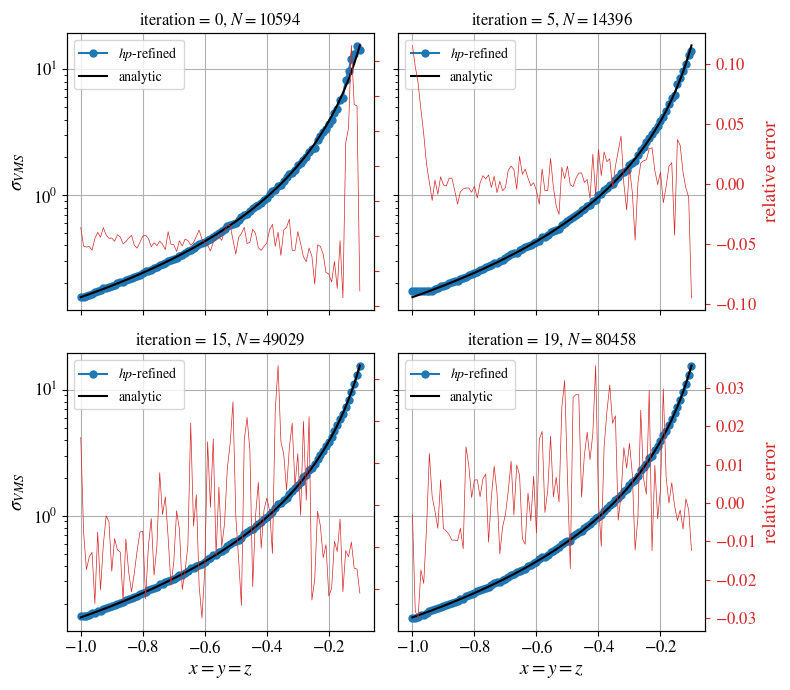

In [15]:
# Load data.
file = '../data/final/results_boussinesq_hp_e5.h5'
data = h5.File(file, 'r')
pos = data['domain_00000/pos'][:]
x_min = min(pos[0])
x_max = max(pos[0])
data.close()

# Obtain analytic solution
coord_test = np.linspace(x_min, x_max, 100)
disp_x, disp_y, disp_z, sxx, syy, szz, sxy, sxz, syz = analytic(
    coord_test, coord_test, coord_test, -1, 1, 0.33)
vms_analytic = get_vms(sxx, syy, szz, sxy, sxz, syz)

# Plot iterations.
iteration_idxs = [0, 5, 15, 19]
fig, axs = plt.subplots(2, 2, figsize=(8, 7), sharex=True, sharey=True)
data = h5.File(file, 'r')
handles = []
labels = []
for i, ax in enumerate(axs.flatten()):
    pos = np.array(
        data['domain_{:05d}/pos'.format(iteration_idxs[i])][:]).transpose()
    stress = data['stress_implicit_{:05d}'.format(iteration_idxs[i])][:]
    sxx = stress[0]
    syy = stress[1]
    szz = stress[2]
    sxy = stress[3]
    sxz = stress[4]
    syz = stress[5]
    vms = get_vms(sxx, syy, szz, sxy, sxz, syz)

    # Build Sheppards interpolant.
    sheppard = idw(pos, vms)

    # Use Sheppards interpolant to plot VMS along diagonal.
    VMS_interpolated = [sheppard([x, x, x], n_neighbors=5) for x in coord_test]

    p, = ax.plot(coord_test, VMS_interpolated, '.-',
                 label=r'${}$-refined'.format('hp'), ms=10)
    if i == 0:
        handles.append(p)
    p, = ax.plot(coord_test, vms_analytic, '-k', label=r'analytic')
    if i == 0:
        handles.append(p)
    ax.grid('both')
    ax.set_title('iteration = {}, $N={}$'.format(iteration_idxs[i], len(sxx)))
    ax.set_yscale('log')
    ax.legend()

    # Absolute error.
    ax = ax.twinx()
    p, = ax.plot(coord_test, (VMS_interpolated - vms_analytic) /
                 vms_analytic, '-', lw=0.5, c='tab:red')
    if i == 0:
        handles.append(p)
    ax.yaxis.label.set_color(p.get_color())   
    if (i % 2) == 1:
        ax.set_ylabel('relative error')
    else:
        ax.axes.yaxis.set_ticklabels([])
    ax.tick_params(axis='y', colors=p.get_color())
    # ax.grid('both')

axs[0][0].set_ylabel(r'$\sigma_{VMS}$')
axs[1][0].set_ylabel(r'$\sigma_{VMS}$')
axs[1][0].set_xlabel(r'$x=y=z$')
axs[1][1].set_xlabel(r'$x=y=z$')

fig.tight_layout()

data.close()
plt.show()

if 0:
    plt.savefig('../manuscript/figures/iterations_boussinesq.eps',
                dpi=300, transparent=False, bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


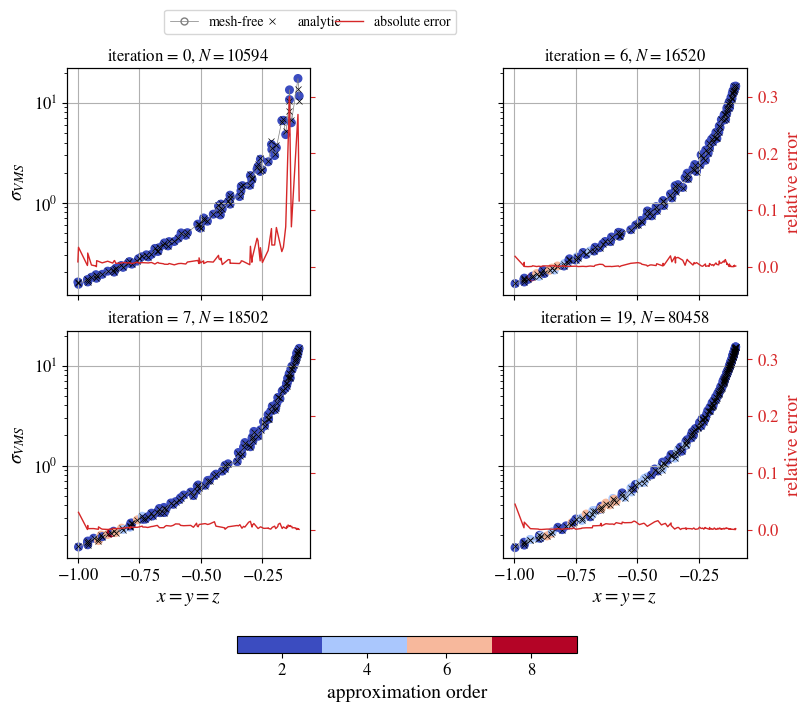

In [16]:
# Load data.
file = '../data/final/results_boussinesq_hp_e5.h5'

data = h5.File(file, 'r')
pos = data['domain_00000/pos'][:]
x_min = min(pos[0])
x_max = max(pos[0])
data.close()
cmap = plt.get_cmap('coolwarm', 4)    # 4 discrete colors

# Obtain analytic solution
coord_test = np.linspace(x_min, x_max, 100000)

# Plot iterations.
iteration_idxs = [0, 6, 7, 19]
fig, axs = plt.subplots(2, 2, figsize=(8, 7), sharex=True,
                        sharey=True, constrained_layout=True)
data = h5.File(file, 'r')
handles = []
labels = []
for i, ax in enumerate(axs.flatten()):
    handles = []
    labels= []

    pos = np.array(
        data['domain_{:05d}/pos'.format(iteration_idxs[i])][:]).transpose()
    typ = np.array(
        data['domain_{:05d}/types'.format(iteration_idxs[i])][:]).transpose()
    N = len(pos[:, 0])
    stress = data['stress_implicit_{:05d}'.format(iteration_idxs[i])][:]
    vms = get_vms(stress[0], stress[1], stress[2],
                  stress[3], stress[4], stress[5])

    # Obtain nodes closest to body diagonal (-1, -1, -1) -> (-eps, -eps, -eps).
    tree = KDTree(pos, leaf_size=5)
    closest_idx = []
    for j, coord in enumerate(coord_test):
        dist, ind = tree.query([[coord, coord, coord]], k=2)
        ind = list(ind[0])
        closest_idx += ind

    closest_idx = np.unique(closest_idx)

    # Coordinates and values.
    pos = pos[closest_idx]
    vms = vms[closest_idx]
    typ = typ[closest_idx]

    x = pos[:, 0]
    y = pos[:, 1]
    z = pos[:, 2]
    x_sorted, y = zip(*sorted(zip(x, y)))
    x_sorted, z = zip(*sorted(zip(x, z)))
    x_sorted, vms = zip(*sorted(zip(x, vms)))
    p, = ax.plot(x_sorted, vms, '-o', c='tab:gray', ms=5, label=r'mesh-free', lw=0.5, mfc="none")
    p.remove()
    handles.append(p)
    p, = ax.plot(x_sorted, vms, '-', c='tab:gray', ms=3, label=r'mesh-free', lw=0.5, mfc="none")
    pp = ax.scatter(x_sorted, vms, c=typ, s=30, cmap=cmap, vmin=2, vmax=8)

    # Analytic.
    disp_x, disp_y, disp_z, sxx, syy, szz, sxy, sxz, syz = analytic(
        x_sorted, y, z, -1, 1, 0.33)
    vms_analytic = get_vms(sxx, syy, szz, sxy, sxz, syz)
    p, = ax.plot(x_sorted, vms_analytic, 'xk', ms=5,  label=r'analytic', markeredgewidth=0.5)
    handles.append(p)
    ax.grid('both')
    ax.set_title('iteration = {}, $N={}$'.format(iteration_idxs[i], N))
    ax.set_yscale('log')

    # Absolute error.
    axx = ax.twinx()
    p, = axx.plot(x_sorted, np.abs(vms - vms_analytic) /
                 vms_analytic, '-', lw=1, c='tab:red')
    
    handles.append(p)
    axx.yaxis.label.set_color(p.get_color())   
    if (i % 2) == 1:
        axx.set_ylabel('relative error')
    else:
        axx.axes.yaxis.set_ticklabels([])
    axx.tick_params(axis='y', colors=p.get_color())
    axx.set_ylim(top=0.35, bottom=-0.05)
    # ax.grid('both')
    if (i == 0):
        ax.legend(handles=handles, labels=['mesh-free','analytic', 'absolute error'], bbox_to_anchor=(0.4, 1.15, 1.2, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)


axs[0][0].set_ylabel(r'$\sigma_{VMS}$')
axs[1][0].set_ylabel(r'$\sigma_{VMS}$')
axs[1][0].set_xlabel(r'$x=y=z$')
axs[1][1].set_xlabel(r'$x=y=z$')

cbar = fig.colorbar(pp, ax=axs, location='bottom', pad=0.05, ticks=[
                    2.8, 4.3, 5.7, 7.2], shrink=0.5, label='approximation order')
cbar.ax.set_xticklabels(labels=np.arange(2, 9, 2))

data.close()

if 1:
    plt.savefig('../manuscript/figures/iterations_boussinesq.eps',
                dpi=300, transparent=False, bbox_inches='tight')
plt.show()


In [48]:
file = '../data/results_007348.h5'
data = h5.File(file, 'r')
best_idx = 19
typ = np.abs(np.array(data['domain_{:05d}/types'.format(best_idx)][:])).transpose()
data.close()
unique_types = np.unique(typ)

fig, ax = plt.subplots(1,1, figsize=(5, 3))
a = ax.hist(typ, bins=len(unique_types), width=0.1, log=True, density=True)
# ax.set_xticks([1,2,3], labels=[2,4,6])
ax.set_ylabel('PDF')
ax.set_xlabel('approximation order')

# plt.suptitle("type distribution")
# fig.tight_layout()
# if 1:
#     plt.savefig('../results/hist_stats.png', dpi=300,
#                 transparent=False, bbox_inches='tight')
# plt.show()

Text(0.5, 0, 'approximation order')

# Plot types

In [20]:
# Import data.
data = h5.File(data_filepath, 'r')

# Obtain HDf groups.
groups = list(data.keys())


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(2, 2, 1, projection='3d')

pos = np.array(data['domain_{:05d}/pos'.format(iteration)][:])
typ = np.abs(data['domain_{:05d}/types'.format(iteration)][:])
print("Types: ", np.unique(typ))
for t in np.unique(typ):
    print("type:", t, ",number:", sum(typ == t))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title('approx order = 2')
idx = typ == 2
p = ax.scatter(pos[0][idx], pos[1][idx], pos[2][idx],
               c=typ[idx], s=marker_size_scatter)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title('approx order = 4')
idx = typ == 4
p = ax.scatter(pos[0][idx], pos[1][idx], pos[2][idx],
               c=typ[idx], s=marker_size_scatter)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_title('approx order = 6')
idx = typ == 6
p = ax.scatter(pos[0][idx], pos[1][idx], pos[2][idx],
               c=typ[idx], s=marker_size_scatter)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_title('approx order = 8')
idx = typ == 8
p = ax.scatter(pos[0][idx], pos[1][idx], pos[2][idx],
               c=typ[idx], s=marker_size_scatter)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.view_init(elev=37., azim=27)

fig.tight_layout()

data.close()


Types:  [2 4 6]
type: 2 ,number: 74391
type: 4 ,number: 5937
type: 6 ,number: 130


# Plot indicator distribution

In [6]:
file = '../data/final/results_boussinesq_hp_e6.h5'
# Plot iterations.
fig, axs = plt.subplots(1, 5, figsize=(20, 15))
data = h5.File(file, 'r')
iteration_idxs = np.arange(0, 5)

for i, ax in enumerate(axs.flatten()):
    indicator = data['analytic_error_{:05d}'.format(iteration_idxs[i])][:][0]
    indicator = data['indicator_{:05d}'.format(iteration_idxs[i])][:]
    indicator /= np.max(indicator)
    # find only highest indicators.
    # use = indicator < 100
    # indicator = indicator[use]

    p = ax.hist(indicator, 100)
    ax.set_title('iteration = {}'.format(iteration_idxs[i]))
    ax.set_xlabel(r'indicator value')
    ax.set_ylabel(r'count')
    ax.set_yscale('log')

data.close()
fig.tight_layout()
print(p)


(array([6.186e+03, 1.804e+03, 7.510e+02, 4.890e+02, 3.520e+02, 2.430e+02,
       2.140e+02, 1.590e+02, 1.570e+02, 1.190e+02, 1.030e+02, 1.130e+02,
       9.800e+01, 9.500e+01, 7.600e+01, 7.600e+01, 6.600e+01, 5.200e+01,
       5.100e+01, 4.400e+01, 4.900e+01, 4.900e+01, 5.100e+01, 4.500e+01,
       2.800e+01, 3.700e+01, 2.800e+01, 3.100e+01, 2.000e+01, 2.600e+01,
       3.100e+01, 2.700e+01, 2.100e+01, 2.600e+01, 2.100e+01, 1.200e+01,
       2.400e+01, 7.000e+00, 1.700e+01, 1.100e+01, 9.000e+00, 5.000e+00,
       7.000e+00, 1.400e+01, 1.100e+01, 1.000e+00, 4.000e+00, 5.000e+00,
       7.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 5.000e+00,
       3.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
       1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,

# Plot highest indicator value for selected iterations

In [7]:
# Import data.
data = h5.File('../data/final/results_boussinesq_hp_e6.h5', 'r')

# Obtain HDf groups.
groups = list(data.keys())


fig = plt.figure(figsize=(12, 12))

indexes = [0, 1, 2, 3]

for i, idx in enumerate(indexes):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')

    pos = np.array(data['domain_{:05d}/pos'.format(idx)][:])
    indicator = data['indicator_{:05d}'.format(idx)][:]
    # find only highest indicators.
    use = indicator > 10
    x = pos[0][use]
    y = pos[1][use]
    z = pos[2][use]
    indicator = indicator[use]

    ax.set_title('iteration = {}'.format(idx))
    p = ax.scatter(x, y, z, indicator, cmap='jet', s=marker_size_scatter * 3)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    ax.view_init(elev=37., azim=27)

data.close()


c:\Users\mitja\AppData\Local\Programs\Python\Python310\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:906: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
c:\Users\mitja\AppData\Local\Programs\Python\Python310\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:908: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


In [19]:
x

array([], dtype=float64)